In [ ]:
!pip install transformers
!pip install pytorch-lightning
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification # Bert Scibert siebert
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown 1UuZ-cxMLuDkG5MA5Fro-FukogZwrbhyM
!gdown 10q2P_OOGdCDeQjXXztrE_id3FkGMovoK
!gdown 1iAiuVySC1TsbKzCcKkSR74L9dWzfeLIx

Downloading...
From: https://drive.google.com/uc?id=1UuZ-cxMLuDkG5MA5Fro-FukogZwrbhyM
To: /content/validateKFold.csv
100% 222k/222k [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=10q2P_OOGdCDeQjXXztrE_id3FkGMovoK
To: /content/trainKFold.csv
100% 1.59M/1.59M [00:00<00:00, 187MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iAiuVySC1TsbKzCcKkSR74L9dWzfeLIx
To: /content/testKFold.csv
100% 199k/199k [00:00<00:00, 49.7MB/s]


In [ ]:

path_test = "/content/testKFold.csv"
path_train = "/content/trainKFold.csv"
path_validate = "/content/validateKFold.csv"

test_data = pd.read_csv(path_test)
train_data = pd.read_csv(path_train)
validate_data = pd.read_csv(path_validate)

attributes = train_data.columns.tolist()[1:]

In [ ]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
from torch.utils.data import Dataset

class Citations_Dataset(Dataset):

  def __init__(self, data_path, tokenizer, attributes, max_token_len: int = 256):
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    data = pd.read_csv(self.data_path)
    self.data = data

    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data.iloc[index]
    citation = str(item.CITATION)
    #attributes = torch.FloatTensor(item[self.attributes])
    labels = item[self.attributes]

    tokens = self.tokenizer.encode_plus(
        citation,
        add_special_tokens=True,
        return_tensors='pt',
        return_token_type_ids=False,
        truncation=True,
        padding='max_length',
        max_length=self.max_token_len,
        return_attention_mask = True
        )
    
    return dict(
      citation_text=citation,
      input_ids=tokens["input_ids"].flatten(),
      attention_mask=tokens["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
train_dataset = Citations_Dataset(
  path_train,
  tokenizer,
  attributes
)

validation_dataset = Citations_Dataset(
  path_validate,
  tokenizer,
  attributes
)

test_dataset = Citations_Dataset(
  path_test,
  tokenizer,
  attributes
)

In [ ]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [ ]:
import numpy as np
import random

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
class Citations_Data_Module(pl.LightningDataModule):

  def __init__(self, train_path, val_path, test_path, attributes, batch_size = 8, max_token_length: int = 256, tokenizer= tokenizer):
    super().__init__()
    self.train_path = train_path
    self.val_path = val_path
    self.test_path = test_path
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_length = max_token_length
    self.tokenizer = tokenizer

  def setup(self, stage = None):
    if stage in (None, "fit"):
      self.train_dataset = Citations_Dataset(self.train_path, tokenizer=self.tokenizer, attributes=self.attributes)
      self.val_dataset = Citations_Dataset(self.val_path, tokenizer=self.tokenizer, attributes=self.attributes)
    if stage == 'predict':
      self.test_dataset = Citations_Dataset(self.test_path, attributes=self.attributes, tokenizer=self.tokenizer, sample=None)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=4, worker_init_fn=seed_worker, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, worker_init_fn=seed_worker, shuffle=False)

  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size = self.batch_size, num_workers=4, worker_init_fn=seed_worker, shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
#Data_module = Citations_Data_Module(path_train, path_validate, attributes=attributes)
Data_module = Citations_Data_Module(path_train, path_validate, path_test, attributes=attributes)

In [ ]:
Data_module.setup()

# Model

In [ ]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torchmetrics
import torch.nn.functional as F

In [ ]:
target = torch.tensor([0.7/3, 0.1/3, 2.2/3], dtype=torch.float)

In [ ]:
class Citation_Classifier(pl.LightningModule):
    
  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    torch.nn.init.xavier_uniform_(self.hidden.weight)
    self.loss_func = nn.CrossEntropyLoss(weight = config['weights'])
    self.dropout = nn.Dropout()
    self.soft = nn.Softmax(dim=1)
   
  def forward(self, input_ids, attention_mask, labels=None):
    # scibert
    output = self.pretrained_model(input_ids=input_ids, attention_mask = attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = self.dropout(pooled_output)
    pooled_output = F.relu(pooled_output)
    
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output) 
    #logits =  self.soft(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    # loss, outputs = self(**batch)
    # self.log("train loss ", loss, prog_bar = True, logger=True)
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_index):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(attributes):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    total_steps = self.config['train_size']/self.config['batch_size'] # The n training step
    warmup_steps = math.floor(total_steps * self.config['warmup'])

    #'warmup': 32, # (len(Data_module.train_dataloader())/4)/5 or tot steps * 0.2

    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]


In [ ]:
config = {
    'model_name': model_name,
    'n_labels': len(attributes),
    'batch_size': 32,
    'lr': 1.5e-5,
    'warmup': 0.2, 
    'train_size': len(Data_module.train_dataloader()),
    'weight_decay': 0.00,
    'n_epochs': 4,
    'weights' : target
}

In [ ]:
model = Citation_Classifier(config)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Train model

In [ ]:
trainer = pl.Trainer()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1767: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,


In [ ]:
!gdown 1-ip2Djb3_nvSoh9dIIuqWp755TqJdtBt # modèle scibert

Downloading...
From: https://drive.google.com/uc?id=1-krxflv6S5mY84E077KXf1l3KXiUIkjz
To: /content/best-checkpoint.ckpt
100% 1.32G/1.32G [00:05<00:00, 229MB/s]


In [ ]:
trained_model_path = '/content/best-checkpoint.ckpt'
trained_model = Citation_Classifier.load_from_checkpoint(trained_model_path, config = config)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trained_model.eval()
trained_model.freeze()
trained_model.cpu()

Ici on test le modèle sur une citation d'un sentiment connu:
a = test_data[test_data.Positive == 1].sample()
indique qu'on récupère une citation de sentiment positif et on effectue le test.

In [ ]:
# Test the model on 1 random citation
a = test_data[test_data.Positive == 1].sample()
#a = test_data.sample()
test_citation = a.CITATION.values[0]
print(a[['Positive', 'Objective', 'Negative']])
print('=--------------------------------------=')

encoding = tokenizer.encode_plus(
  test_citation,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = nn.Softmax(dim=1)(test_prediction)
test_prediction = test_prediction.flatten().numpy()
#test_prediction = test_prediction.detach().numpy()
for label, prediction in zip(attributes, test_prediction):
  print(f"{label}: {prediction}")

     Positive  Objective  Negative
248         1          0         0
=--------------------------------------=


RuntimeError: ignored

# Evaluation

Ici on lance l'evaluation de l'ensemble de test

In [ ]:
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

predictions = []
labels = []

for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  prediction = nn.Softmax(dim=1)(prediction)#
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
  
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/874 [00:00<?, ?it/s]

In [ ]:
from torchmetrics.functional import accuracy, auroc
THRESHOLD = 0.5
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.4683)

In [ ]:
print("AUROC per tag")

for i, name in enumerate(attributes):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Positive: 0.4655653238296509
Objective: 0.5373554229736328
Negative: 0.4625132381916046


In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

#let’s check the classification report for each class.
#To make this work, we must apply thresholding to the predictions:
  
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=attributes
))

              precision    recall  f1-score   support

    Positive       0.05      0.08      0.06        75
   Objective       0.00      0.00      0.00       778
    Negative       0.02      0.43      0.04        21

   micro avg       0.03      0.02      0.02       874
   macro avg       0.02      0.17      0.03       874
weighted avg       0.01      0.02      0.01       874
 samples avg       0.02      0.02      0.02       874



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matrices de confusion

[[ 32   0  43]
 [394   0 384]
 [ 12   0   9]]


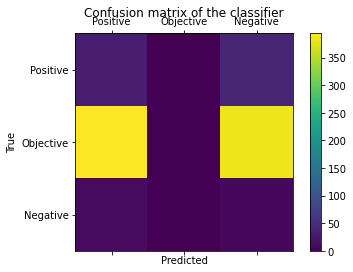

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + attributes)
ax.set_yticklabels([''] + attributes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

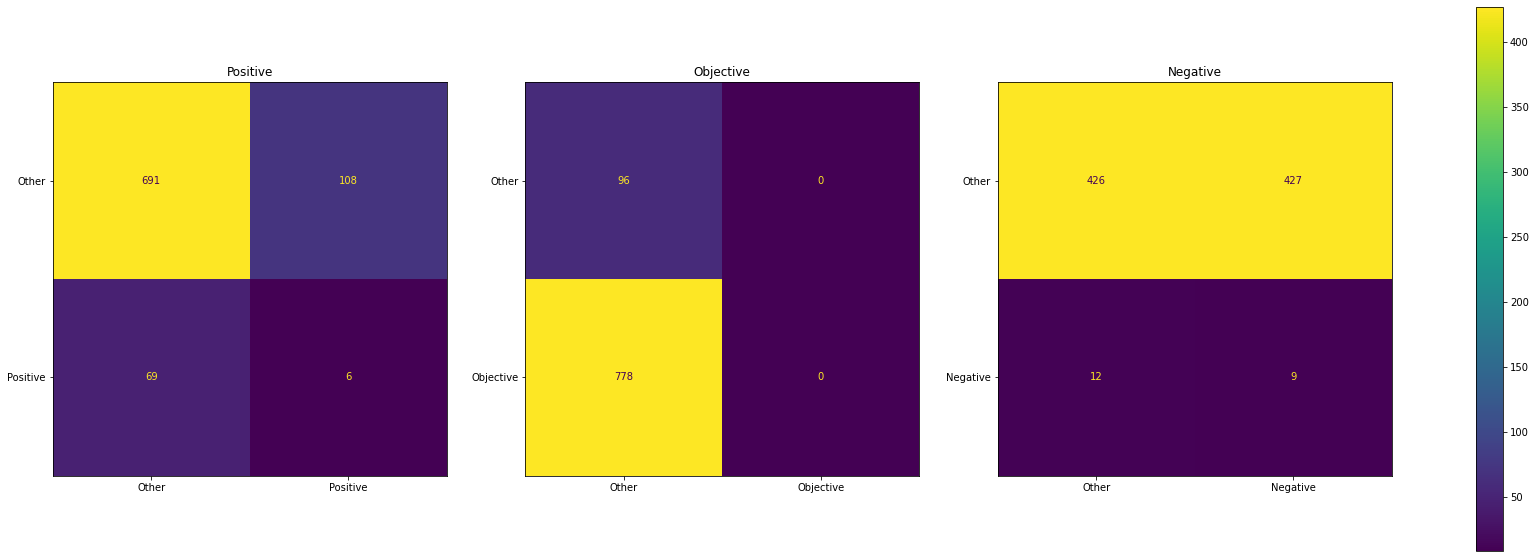

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier

f, axes = plt.subplots(1, 3, figsize=(30, 10))
for i in range(3):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i],
                                                   y_pred[:, i]),
                                  display_labels=["Other", attributes[i]])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(attributes[i])
    disp.im_.colorbar.remove()
    disp.ax_.set(
                title=attributes[i], 
                xlabel='', 
                ylabel='')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
f.colorbar(disp.im_, ax=axes)
plt.show()


Affichage des graphes de loss, le chemin doit être manuelement changé à chaque fois puisqu'on n'execute pas du code python, on ne peut pas utiliser des variables. 

In [ ]:
tensorboard_path = MODEL_PATH+MODEL_SAVING_NAME+'/lightning_logs/'
tensorboard_path

NameError: ignored

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/Studies/PFE Master/scibert_BCE_Soft/lightning_logs/"